<a href="https://colab.research.google.com/github/MadimetjaMadix/action-recognition-vowels/blob/main/Vowels_Action_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import and Install dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [ ]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from matplotlib import pyplot as plt

## Keypoints using MP Holistic


In [ ]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities

In [ ]:
def mediapipe_detection(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion BGR -> RGB
  image.flags.writeable = False                   # disable Image writeable
  results = model.process(image)                  # Make Holistic Predictions
  image.flags.writeable = True                    # enable Image Writeable
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion RGB -> BGR
  return image, results

In [ ]:
def draw_landmarks(image, results):
  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)       # Draw face Connections
  mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)        # Draw pose Connections
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)   # Draw left hand Connections
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw right hand Connections

In [115]:
vid_path = '/content/drive/My Drive/SASL_Vowels/I/I_9.mp4'
cap = cv2.VideoCapture(vid_path)
last_fr = None
last_res = None

  # Set mediapipe model
  with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
    # process the video
    while cap.isOpened():

      # read frame
      ret, frame = cap.read()

      # break if there are no frames to be read
      if not ret:
            break
      
      # make detections
      image, results = mediapipe_detection(frame, holistic)
      if results.right_hand_landmarks:
        #print(results.right_hand_landmarks)
        #cv2_imshow( frame)
        last_fr = frame
        last_res = results

      # live web cam
        #draw_landmarks(image, results)
        #cv2_imshow(image)

      # breake if i say so
      if cv2.waitKey(10) and 0xff == ord('q'):
        break
    cv2.destroyAllWindows()
    cap.release()


Test to see the landmarks

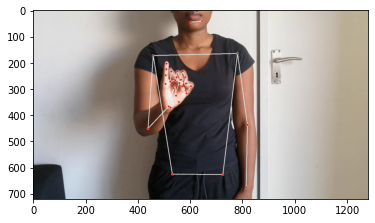

In [116]:
draw_landmarks(last_fr, last_res)
plt.imshow(cv2.cvtColor(last_fr, cv2.COLOR_BGR2RGB))

## **Extracting Keypoint Values**

In [106]:
def extract_keypoints(results):
  hand_kp = 21*3    # number of hand key points 63
  pose_kp = 33*4    # number of pose key points 132
  face_kp = 468*3    # number of face key points 1404

  face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(face_kp)
  pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(pose_kp)
  l_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(hand_kp)
  r_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(hand_kp)

  #focus on pose and r_hand for now
  # else return np.concatenate([pose, face, l_hand, r_hand])

  return np.concatenate([pose, r_hand]) # 63 + 132 = 195 values


In [108]:
len(extract_keypoints(results))

195

## **Data Folders**

In [110]:
core_dir = '/content/drive/My Drive'
videos_src = '/content/drive/My Drive/SASL_Vowels'
folder_name = 'Vowels_Data'
data_path = os.path.join(core_dir,folder_name)

#Vowels Folders
vowels = np.array(['A', 'E', 'I', 'O', 'U'])

# no of videos ?? at least 50 valid videos
num_frames = 50



Data Extraction

In [122]:

def key_value_extractor(vid_path, output_path):
  
  cap = cv2.VideoCapture(vid_path)
  frame_count = 0
  # Set mediapipe model
  with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.5) as holistic:
    # process the video
    while cap.isOpened():

      # read frame
      ret, frame = cap.read()

      # break if there are no frames to be read
      if not ret:
            break
      
      # make detections
      image, results = mediapipe_detection(frame, holistic)
      keypoints = extract_keypoints(results)
      npy_path = os.path.join(output_path, str(frame_count))
      np.save(npy_path, keypoints)

      frame_count = frame_count + 1
      # live web cam
        #draw_landmarks(image, results)
        #cv2_imshow(image)

      # breake if i say so
      if cv2.waitKey(10) and 0xff == ord('q'):
        break
    cv2.destroyAllWindows()
    cap.release()

In [123]:
# For each Vowel
for vowel_folder in os.listdir(videos_src):
  folder_path = os.path.join(videos_src,vowel_folder)
  for vid in os.listdir(folder_path):
    video_file = os.path.join(folder_path,vid)
    vid_data_folder = os.path.join(data_path,vowel_folder,os.path.splitext(vid)[0])
    try:
      # make a folder if its not there
      os.makedirs(vid_data_folder)
    except:
      pass
    
    # key_value_extractor(video_file, vid_data_folder)    # Done

In [132]:
vid_count = [ {vowel_folder: len(os.path.join(videos_src,vowel_folder))} for vowel_folder in os.listdir(videos_src) ]
vid_count

[{'A': 37}, {'E': 37}, {'I': 37}, {'O': 37}, {'U': 37}]

## **Data Preparation**

In [124]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [127]:
# 5 Vowels
# 37 videos each
# frames >50

label_map = {lable: num for num, lable in enumerate(vowels)} # A dictinary
label_map

{'A': 0, 'E': 1, 'I': 2, 'O': 3, 'U': 4}

# Load the data

In [156]:

num_videos = 37
num_frames = 50
sequences = []
labels = []

for folder in os.listdir(data_path):
  print(folder)
  vid_num = 0
  seq_path = os.path.join(data_path,folder)
  for seq_data in os.listdir(seq_path):
    if vid_num == num_videos:
      break
    vid_num = vid_num + 1
    
    window = []
    frame_num = 0
    seq_data_path = os.path.join(seq_path,seq_data)
    for data_file in os.listdir(seq_data_path):
      if frame_num == num_frames:
        break
      res = np.load(os.path.join(seq_data_path,data_file))
      window.append(res)
      frame_num = frame_num + 1
    sequences.append(window)
    labels.append(label_map[folder])


A
E
I
O
U


Change data to np array and y data to categorical data

In [160]:
np.array(sequences).shape

(185, 50, 195)

In [158]:
np.array(labels).shape

(185,)

In [161]:
x = np.array(sequences)

In [163]:
x.shape

(185, 50, 195)

In [164]:
y = to_categorical(labels).astype(int)

In [166]:
y.shape

(185, 5)

# Train-Test Split The data

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [171]:
x_train.shape

(148, 50, 195)

## **Build and Train LSTM NN**

In [172]:
print('Hello Madix')

Hello Madix
